# Mortality prediction for sepsis patients using XGBoost

## Read data matrix

In [1]:
import pandas as pd
import psycopg2

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'sepsis_icd'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

dataQuery = """select * from sepsis_icd.data_matrix_qc where sepsis = 1;"""
dataDf = pd.read_sql_query(dataQuery, con)
dataDf

,visit_occurrence_id,person_id,discharge_mortality,one_day_mortality,two_day_mortality,thirty_day_mortality,sixty_day_mortality,ninety_day_mortality,sepsis,Ambulatory.Clinic...Center,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
0,-2147304039,1052438339,0,0,0,0,0,0,1,0,...,1.200788,0.333066,-0.815448,-1.186819,-2.843820,2.031557,-0.757336,0.898238,0.816059,-0.736365
1,-2147002424,-1242295740,0,0,0,0,0,0,1,0,...,-2.095619,-0.059306,-0.976023,-0.668035,-0.062589,-0.555414,-0.559555,-1.708890,-1.269585,-0.975811
2,-2144345945,2004496459,0,0,0,0,0,0,1,0,...,-0.932181,-0.500726,-0.092861,1.234175,-0.835153,0.678372,-0.559555,-0.318422,-0.852456,-0.417104
3,-2137779334,1692040065,0,0,0,0,0,0,1,0,...,0.231257,0.578299,-0.815448,-0.149250,-0.680640,-0.256918,-1.944020,0.550621,0.816059,-0.816180
4,-2136505586,-647215717,0,0,0,0,0,0,1,0,...,-1.126087,-0.598819,1.673464,-0.149250,-0.680640,-0.376316,-0.757336,0.376812,-0.375737,2.695693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11206,2144084743,-543633336,0,0,0,0,0,0,1,0,...,0.619069,-0.647865,-0.976023,-0.149250,-1.298691,-0.336517,-0.559555,1.593471,-0.077788,-0.816180
11207,2144805894,-251264248,0,0,0,0,0,0,1,0,...,0.231257,-2.609728,-0.574585,-0.495107,0.555463,-0.595214,0.231568,0.029195,-1.329175,-0.496919
11208,2145278835,1177429874,0,0,0,0,0,0,1,0,...,-1.126087,-1.236424,-0.173148,0.369534,-0.062589,-0.157419,-0.757336,-0.492230,-0.733276,0.221419
11209,2146770624,-1169554980,0,0,0,0,0,0,1,0,...,-0.544368,-0.647865,-0.494298,-1.186819,0.864488,-0.276818,-0.163994,-0.492230,-0.792866,-0.417104


In [2]:
X = dataDf.drop(['visit_occurrence_id', 'person_id', 'discharge_mortality', 'one_day_mortality', 'two_day_mortality', 'thirty_day_mortality', 'sixty_day_mortality', 'ninety_day_mortality', 'sepsis'], axis = 1)
y_discharge = dataDf['discharge_mortality']
y_one_day = dataDf['one_day_mortality']
y_two_day = dataDf['two_day_mortality']
y_thirty_day = dataDf['thirty_day_mortality']
y_sixty_day = dataDf['sixty_day_mortality']
y_ninety_day = dataDf['ninety_day_mortality']

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_discharge_train, y_discharge_test, y_one_day_train, y_one_day_test, y_two_day_train, y_two_day_test, y_thirty_day_train, y_thirty_day_test, y_sixty_day_train, y_sixty_day_test, y_ninety_day_train, y_ninety_day_test = train_test_split(X, y_discharge, y_one_day, y_two_day, y_thirty_day, y_sixty_day, y_ninety_day, test_size=0.2, random_state=42)

In [4]:
X_train.shape, X_test.shape

((8968, 159), (2243, 159))

In [5]:
y_discharge_train.shape, y_discharge_test.shape

((8968,), (2243,))

In [6]:
y_one_day_train.shape, y_one_day_test.shape

((8968,), (2243,))

In [7]:
y_two_day_train.shape, y_two_day_test.shape

((8968,), (2243,))

In [8]:
y_thirty_day_train.shape, y_thirty_day_test.shape

((8968,), (2243,))

In [9]:
y_sixty_day_train.shape, y_sixty_day_test.shape

((8968,), (2243,))

In [10]:
y_ninety_day_train.shape, y_ninety_day_test.shape

((8968,), (2243,))

## Machine Learning using XGBoost

In [11]:
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

### Discharge mortality prediction

In [43]:
lr_discharge = LogisticRegression(fit_intercept=True, max_iter=500)
lr_discharge.fit(X_train, y_discharge_train)
y_discharge_pred = lr_discharge.predict(X_test)

<BarContainer object of 159 artists>

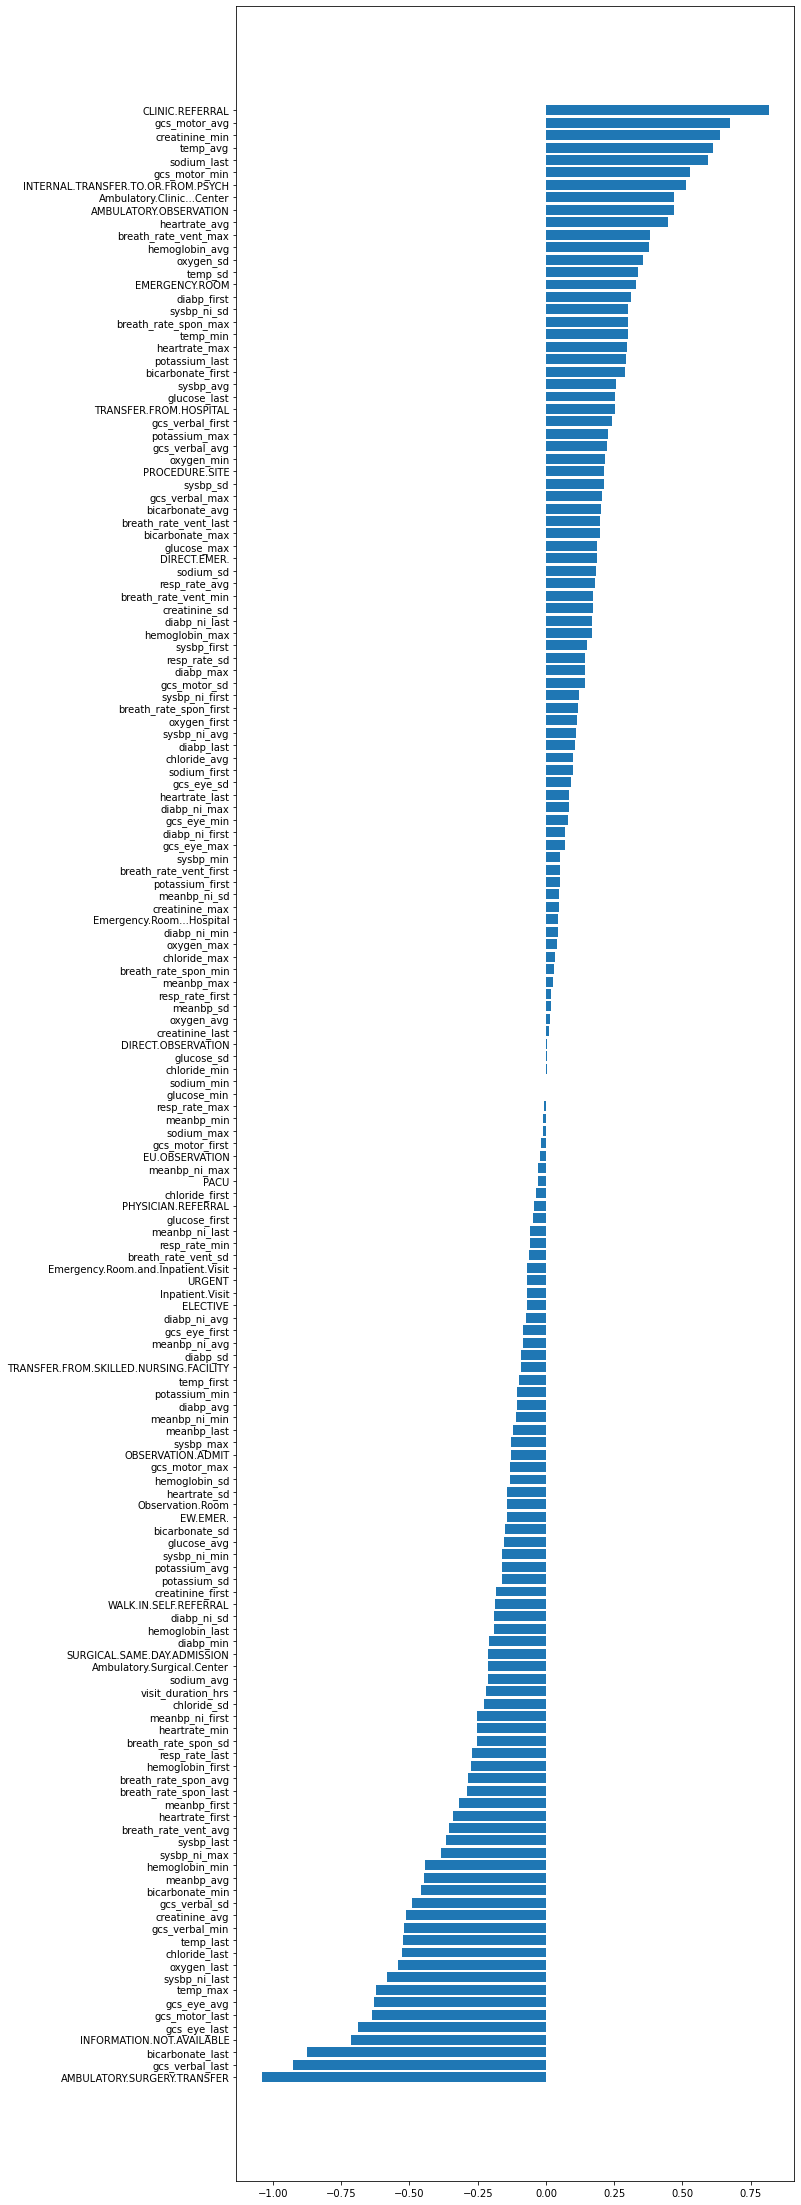

In [44]:
lrDf = pd.DataFrame(data=list(zip(X.columns, lr_discharge.coef_[0])), columns=['feature', 'weight'])
lrDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=lrDf.feature, width=lrDf.weight)

### One-day mortality prediction

In [45]:
lr_one_day = LogisticRegression(fit_intercept=True, max_iter = 500)
lr_one_day.fit(X_train, y_one_day_train)
y_one_day_pred = lr_one_day.predict(X_test)

<BarContainer object of 159 artists>

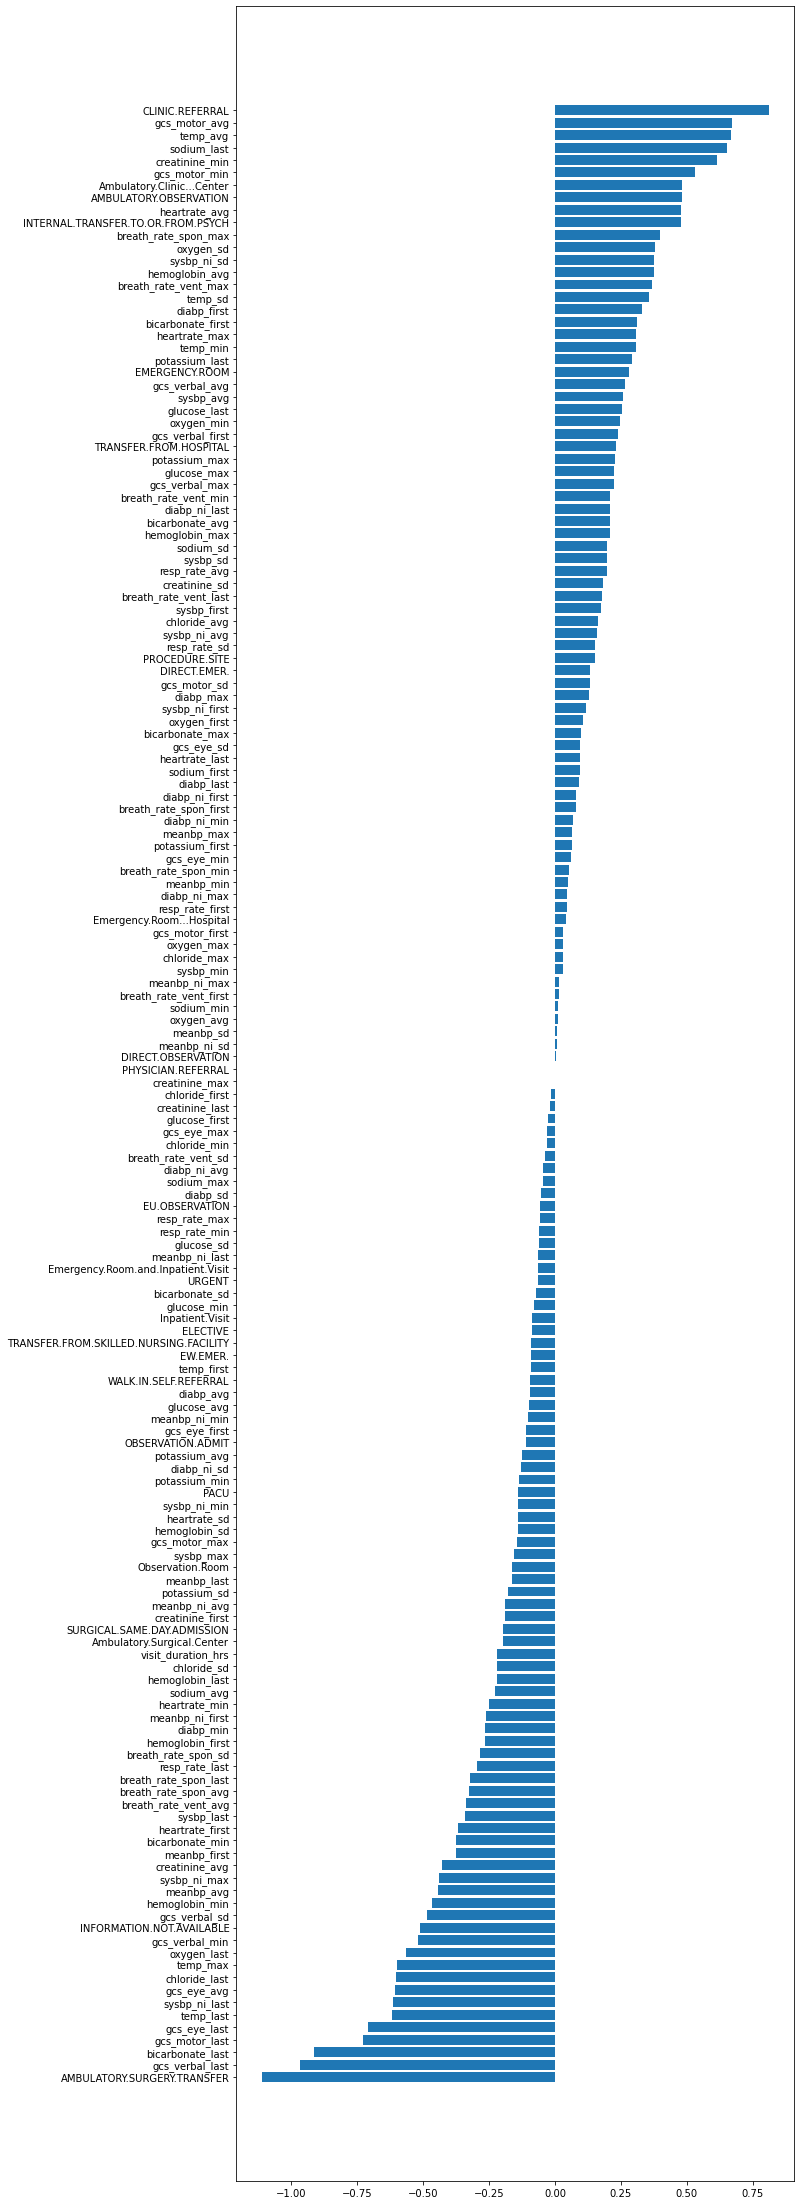

In [46]:
lrDf = pd.DataFrame(data=list(zip(X.columns, lr_one_day.coef_[0])), columns=['feature', 'weight'])
lrDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=lrDf.feature, width=lrDf.weight)

### Two-day mortality prediction

In [47]:
lr_two_day = LogisticRegression(fit_intercept=True, max_iter = 500)
lr_two_day.fit(X_train, y_two_day_train)
y_two_day_pred = lr_two_day.predict(X_test)

<BarContainer object of 159 artists>

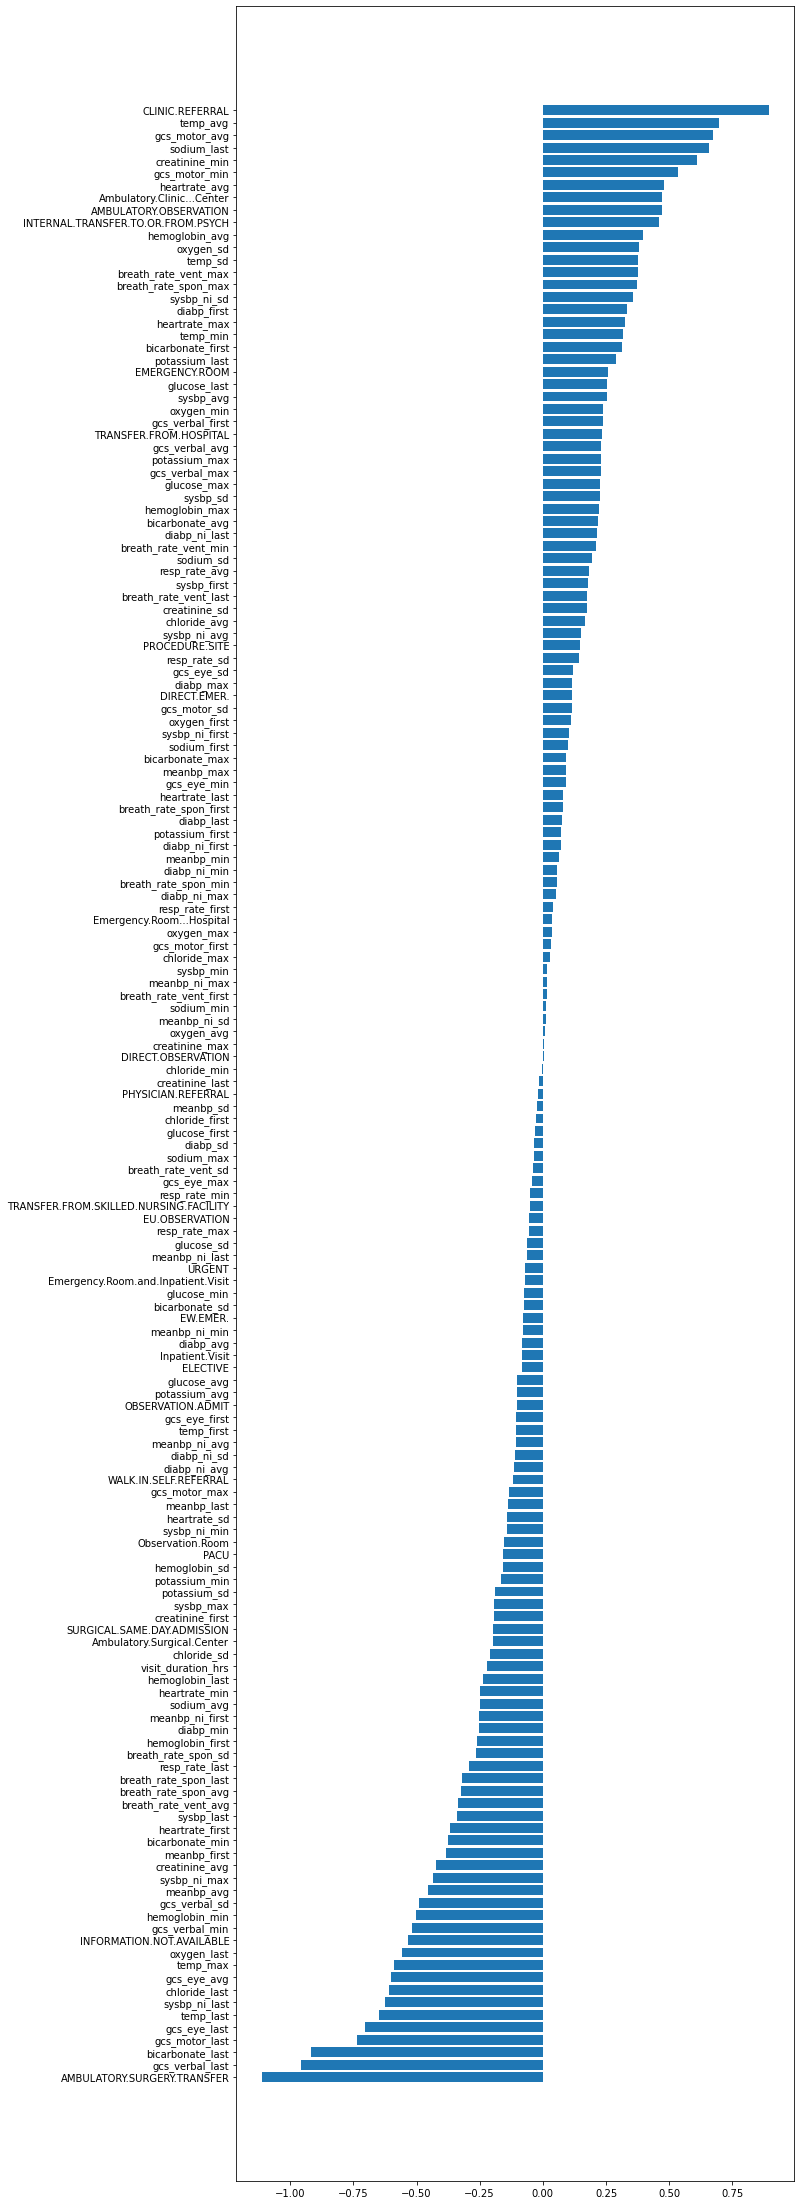

In [48]:
lrDf = pd.DataFrame(data=list(zip(X.columns, lr_two_day.coef_[0])), columns=['feature', 'weight'])
lrDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=lrDf.feature, width=lrDf.weight)

### Thirty-day mortality prediction

In [49]:
lr_thirty_day = LogisticRegression(fit_intercept=True, max_iter = 500)
lr_thirty_day.fit(X_train, y_thirty_day_train)
y_thirty_day_pred = lr_thirty_day.predict(X_test)

<BarContainer object of 159 artists>

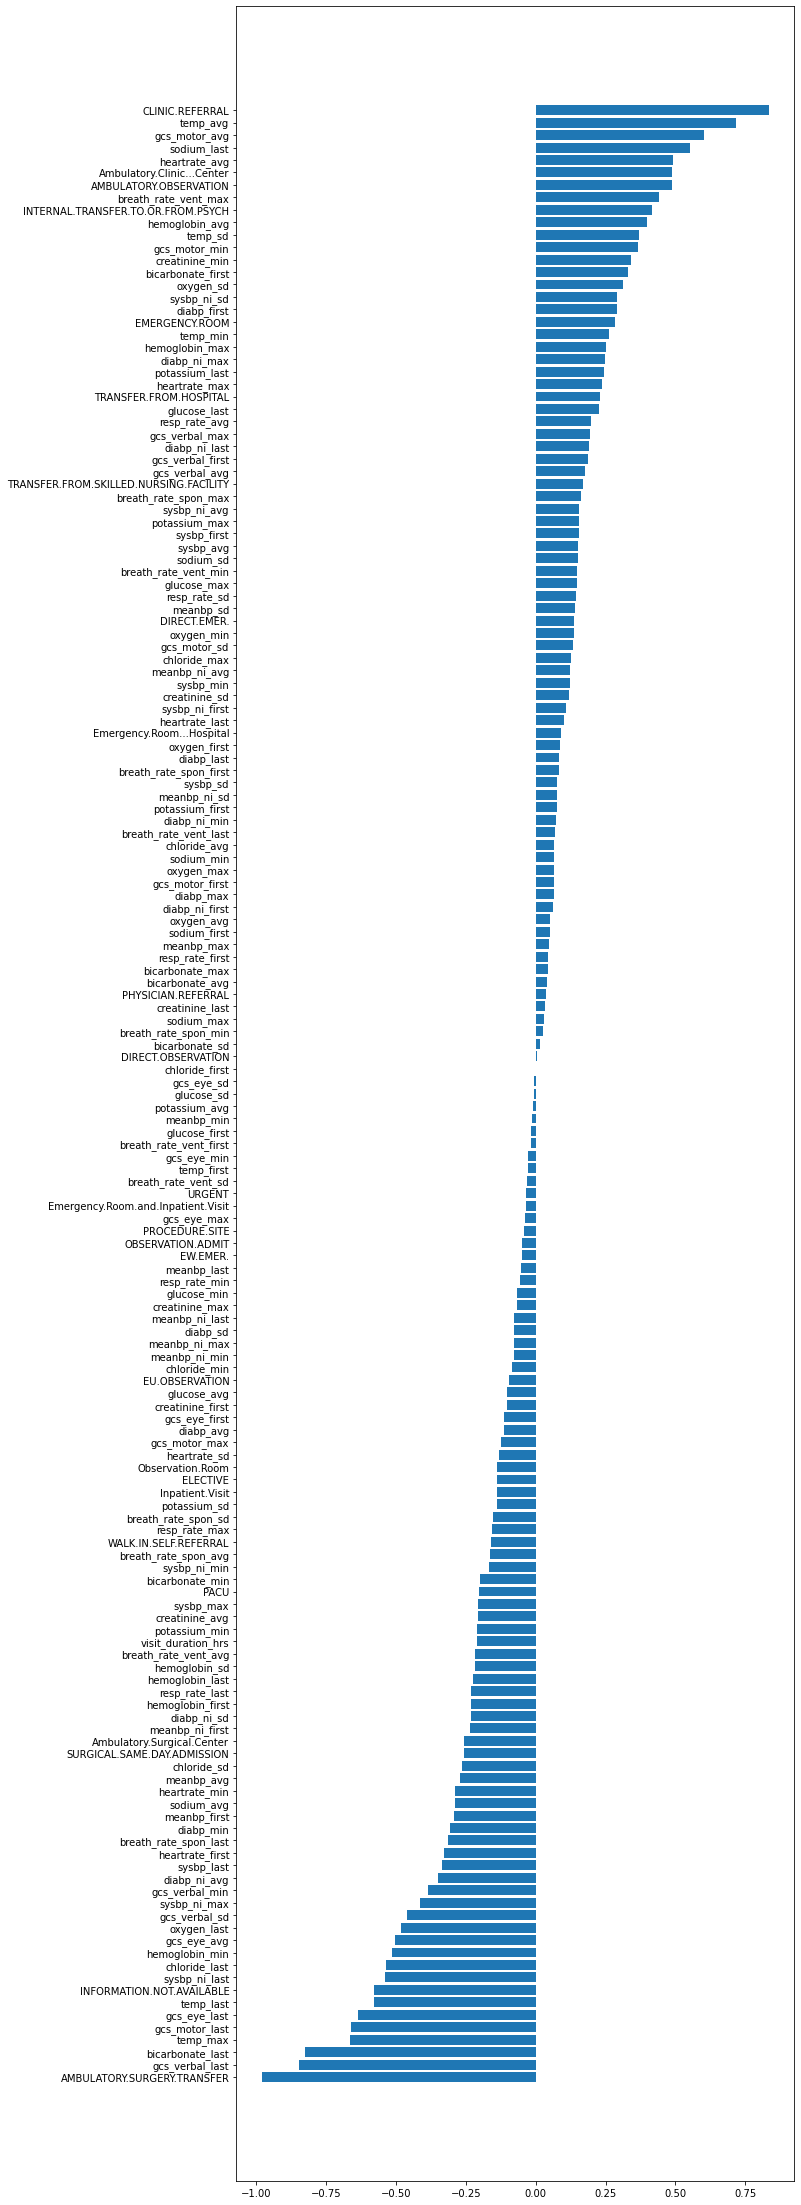

In [50]:
lrDf = pd.DataFrame(data=list(zip(X.columns, lr_thirty_day.coef_[0])), columns=['feature', 'weight'])
lrDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=lrDf.feature, width=lrDf.weight)

### Sixty-day mortality prediction

In [51]:
lr_sixty_day = LogisticRegression(fit_intercept=True, max_iter = 500)
lr_sixty_day.fit(X_train, y_sixty_day_train)
y_sixty_day_pred = lr_sixty_day.predict(X_test)

<BarContainer object of 159 artists>

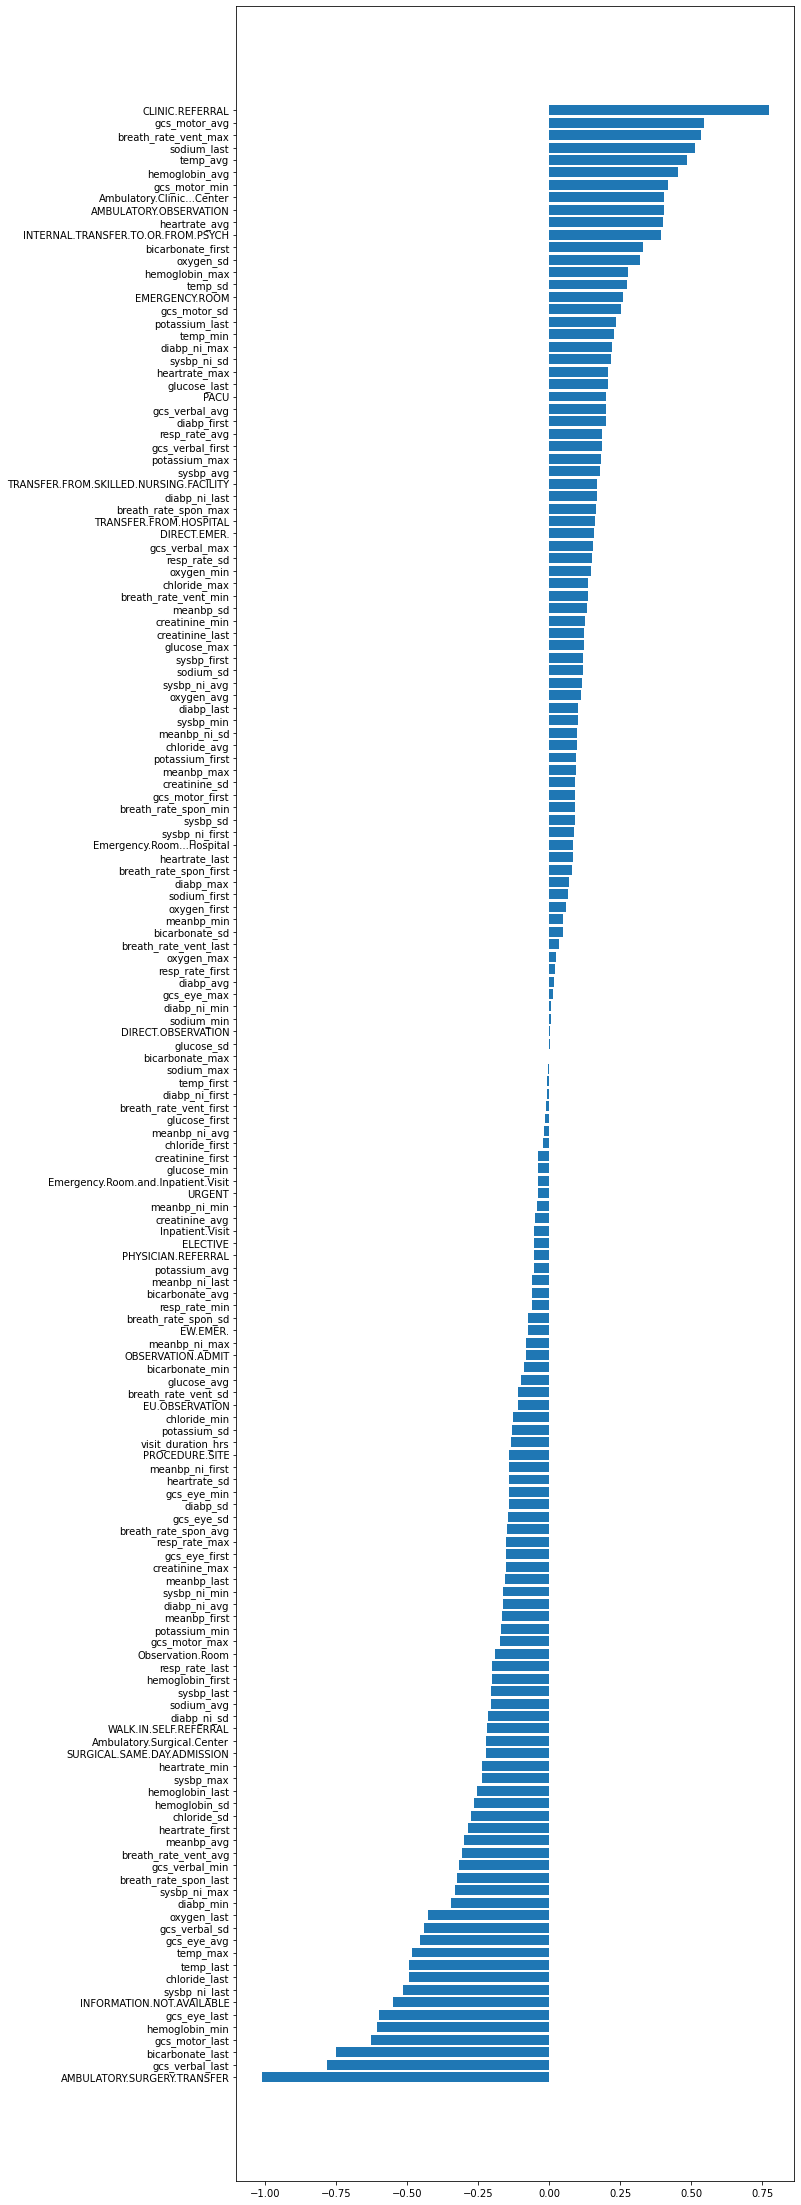

In [52]:
lrDf = pd.DataFrame(data=list(zip(X.columns, lr_sixty_day.coef_[0])), columns=['feature', 'weight'])
lrDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=lrDf.feature, width=lrDf.weight)

### Ninety-day mortality prediction

In [53]:
lr_ninety_day = LogisticRegression(fit_intercept=True, max_iter = 500)
lr_ninety_day.fit(X_train, y_ninety_day_train)
y_ninety_day_pred = lr_ninety_day.predict(X_test)

<BarContainer object of 159 artists>

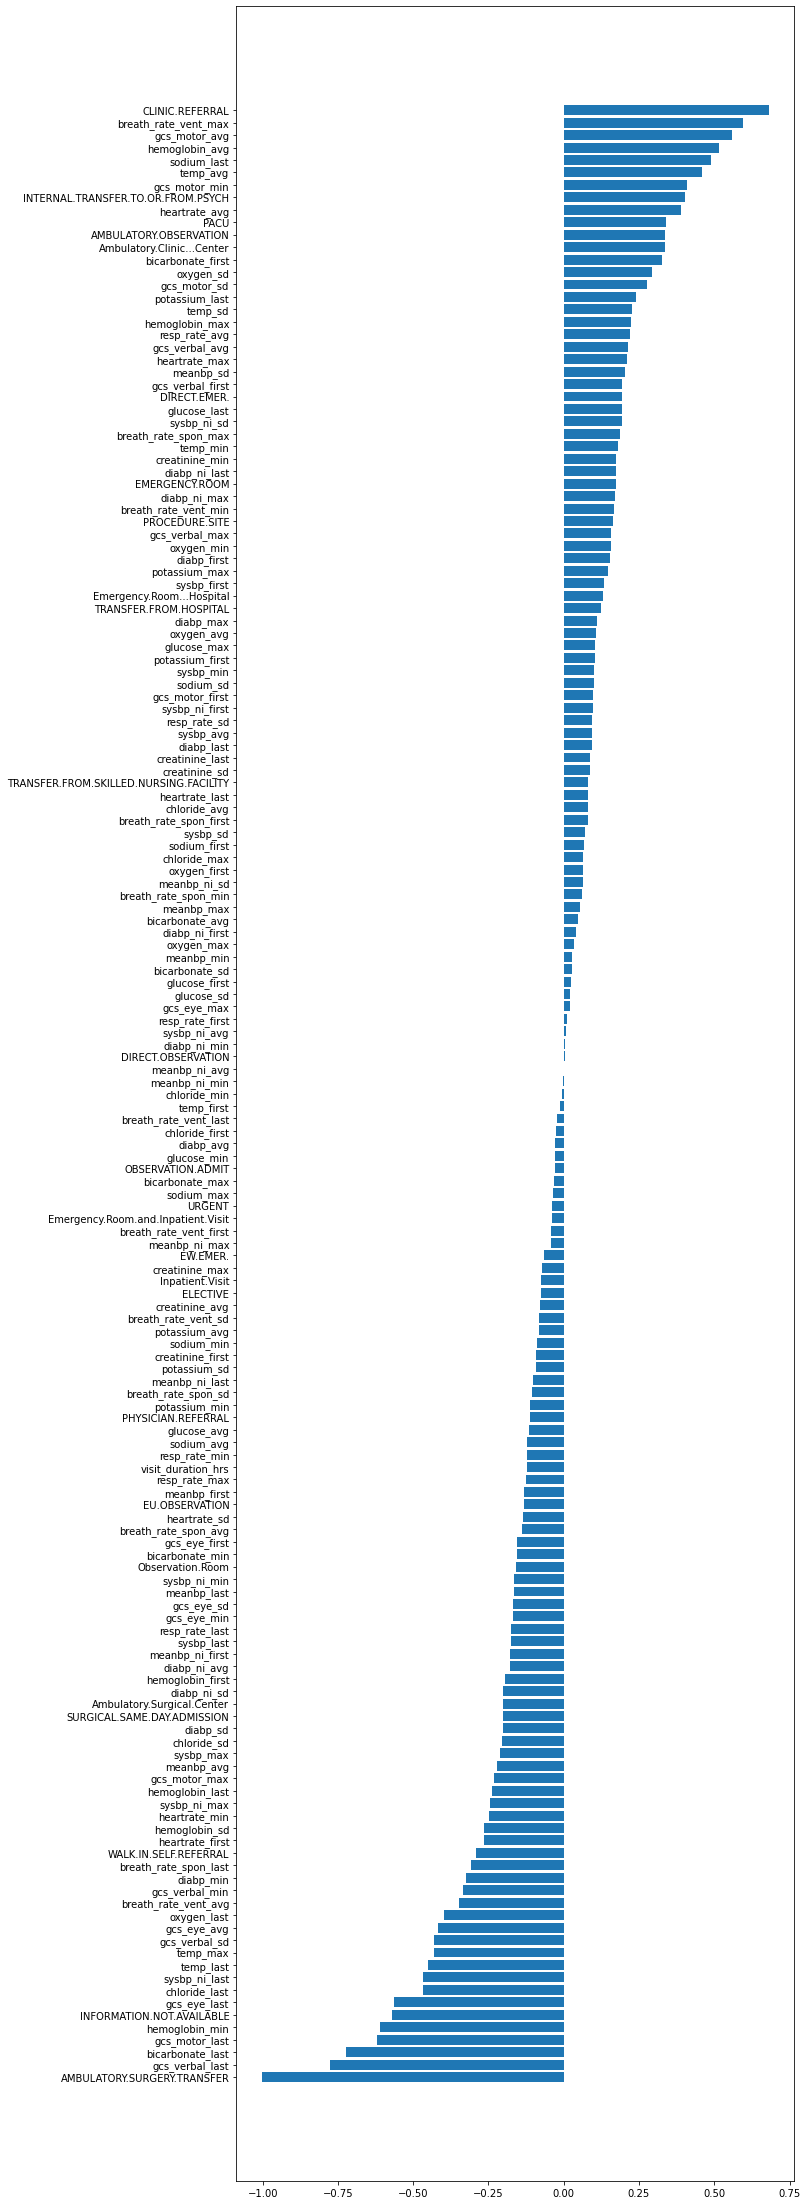

In [54]:
lrDf = pd.DataFrame(data=list(zip(X.columns, lr_ninety_day.coef_[0])), columns=['feature', 'weight'])
lrDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=lrDf.feature, width=lrDf.weight)

### Performance metrics

#### Accuracy

In [55]:
from sklearn.metrics import accuracy_score

print('Discharge mortality accuracy: ', str(accuracy_score(y_discharge_pred, y_discharge_test)))
print('One day mortality accuracy: ', str(accuracy_score(y_one_day_pred, y_one_day_test)))
print('Two day mortality accuracy: ', str(accuracy_score(y_two_day_pred, y_two_day_test)))
print('Thirty day mortality accuracy: ', str(accuracy_score(y_thirty_day_pred, y_thirty_day_test)))
print('Sixty day mortality accuracy: ', str(accuracy_score(y_sixty_day_pred, y_sixty_day_test)))
print('Ninety day mortality accuracy: ', str(accuracy_score(y_ninety_day_pred, y_ninety_day_test)))

Discharge mortality accuracy:  0.9286669638876505
One day mortality accuracy:  0.9286669638876505
Two day mortality accuracy:  0.9295586268390549
Thirty day mortality accuracy:  0.9184128399465002
Sixty day mortality accuracy:  0.9103878733838608
Ninety day mortality accuracy:  0.9054837271511369


#### F1 score

In [56]:
from sklearn.metrics import f1_score

print('Discharge mortality F1: ', str(f1_score(y_discharge_pred, y_discharge_test)))
print('One day mortality F1: ', str(f1_score(y_one_day_pred, y_one_day_test)))
print('Two day mortality F1: ', str(f1_score(y_two_day_pred, y_two_day_test)))
print('Thirty day mortality F1: ', str(f1_score(y_thirty_day_pred, y_thirty_day_test)))
print('Sixty day mortality F1: ', str(f1_score(y_sixty_day_pred, y_sixty_day_test)))
print('Ninety day mortality F1: ', str(f1_score(y_sixty_day_pred, y_sixty_day_test)))

Discharge mortality F1:  0.8160919540229885
One day mortality F1:  0.8181818181818181
Two day mortality F1:  0.8204545454545455
Thirty day mortality F1:  0.8013029315960912
Sixty day mortality F1:  0.7881981032665965
Ninety day mortality F1:  0.7881981032665965


#### Matthews Correlation Coefficient

In [57]:
from sklearn.metrics import matthews_corrcoef

print('Discharge mortality MCC: ', str(matthews_corrcoef(y_discharge_pred, y_discharge_test)))
print('One day mortality MCC: ', str(matthews_corrcoef(y_one_day_pred, y_one_day_test)))
print('Two day mortality MCC: ', str(matthews_corrcoef(y_two_day_pred, y_two_day_test)))
print('Thirty day mortality MCC: ', str(matthews_corrcoef(y_thirty_day_pred, y_thirty_day_test)))
print('Sixty day mortality MCC: ', str(matthews_corrcoef(y_sixty_day_pred, y_sixty_day_test)))
print('Ninety day mortality MCC: ', str(matthews_corrcoef(y_sixty_day_pred, y_sixty_day_test)))

Discharge mortality MCC:  0.7758242159487655
One day mortality MCC:  0.7772825580955759
Two day mortality MCC:  0.780117870238298
Thirty day mortality MCC:  0.7548380191281931
Sixty day mortality MCC:  0.7366956463211525
Ninety day mortality MCC:  0.7366956463211525


#### ROC

In [58]:
from sklearn.metrics import roc_auc_score

print('Discharge mortality ROC: ', str(roc_auc_score(y_discharge_pred, y_discharge_test)))
print('One day mortality ROC: ', str(roc_auc_score(y_one_day_pred, y_one_day_test)))
print('Two day mortality ROC: ', str(roc_auc_score(y_two_day_pred, y_two_day_test)))
print('Thirty day mortality ROC: ', str(roc_auc_score(y_thirty_day_pred, y_thirty_day_test)))
print('Sixty day mortality ROC: ', str(roc_auc_score(y_sixty_day_pred, y_sixty_day_test)))
print('Ninety day mortality ROC: ', str(roc_auc_score(y_sixty_day_pred, y_sixty_day_test)))

Discharge mortality ROC:  0.9116987661140309
One day mortality ROC:  0.910658759416573
Two day mortality ROC:  0.9121567291766842
Thirty day mortality ROC:  0.902292774247714
Sixty day mortality ROC:  0.8933894206188518
Ninety day mortality ROC:  0.8933894206188518


#### Confusion matrix

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10), title='Confusion Matrix for the classifier'):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.title(title)
    plt.show()

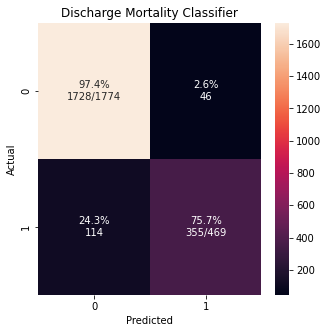

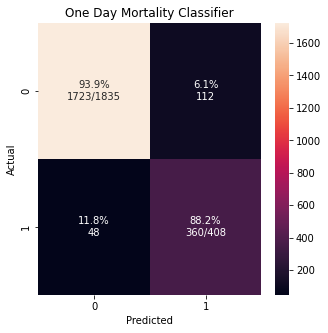

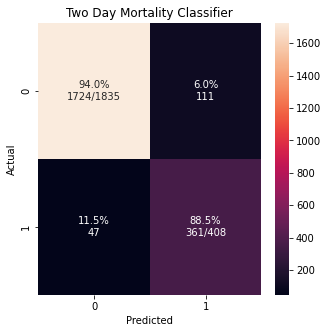

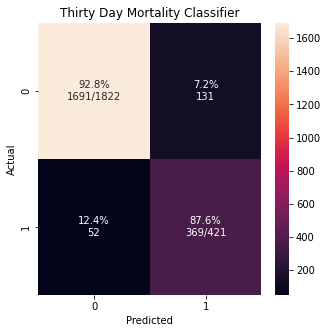

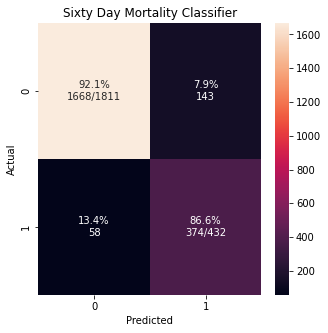

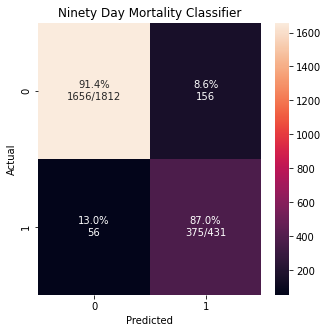

In [60]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(y_discharge_test, y_discharge_pred, labels, ymap=None, figsize=(5, 5), title='Discharge Mortality Classifier')

cm_analysis(y_one_day_pred, y_one_day_test, labels, ymap=None, figsize=(5, 5), title='One Day Mortality Classifier')

cm_analysis(y_two_day_pred, y_two_day_test, labels, ymap=None, figsize=(5, 5), title='Two Day Mortality Classifier')

cm_analysis(y_thirty_day_pred, y_thirty_day_test, labels, ymap=None, figsize=(5, 5), title='Thirty Day Mortality Classifier')

cm_analysis(y_sixty_day_pred, y_sixty_day_test, labels, ymap=None, figsize=(5, 5), title='Sixty Day Mortality Classifier')

cm_analysis(y_ninety_day_pred, y_ninety_day_test, labels, ymap=None, figsize=(5, 5), title='Ninety Day Mortality Classifier')

#### ROC Curve

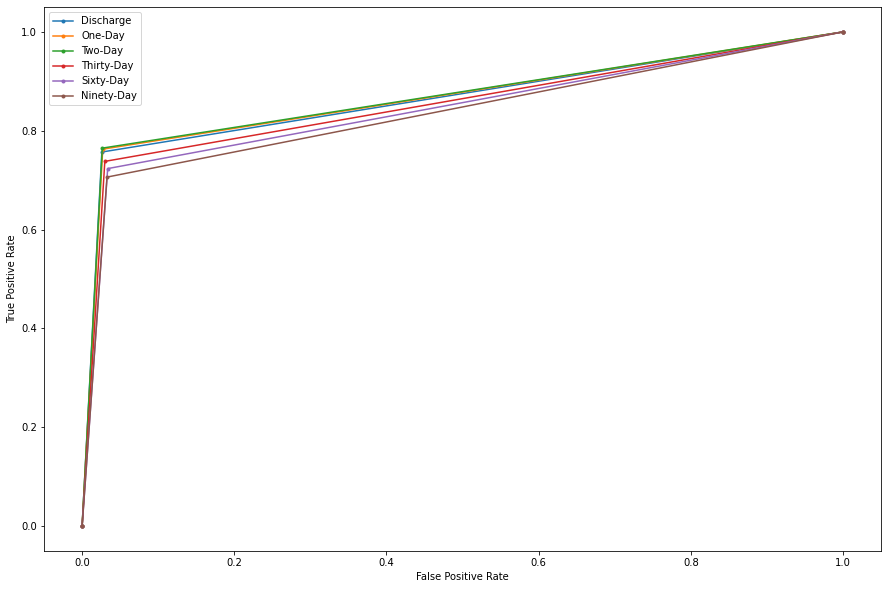

In [61]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,10))

for (pred, test, label) in [
        (y_discharge_pred, y_discharge_test, 'Discharge')
        , (y_one_day_pred, y_one_day_test, 'One-Day')
        , (y_two_day_pred, y_two_day_test, 'Two-Day')
        , (y_thirty_day_pred, y_thirty_day_test, 'Thirty-Day')
        , (y_sixty_day_pred, y_sixty_day_test, 'Sixty-Day')
        , (y_ninety_day_pred, y_ninety_day_test, 'Ninety-Day')
    ]:
    fpr, tpr, _ = roc_curve(test, pred)
    plt.plot(fpr, tpr, marker='.', label=label)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#### PRC curve

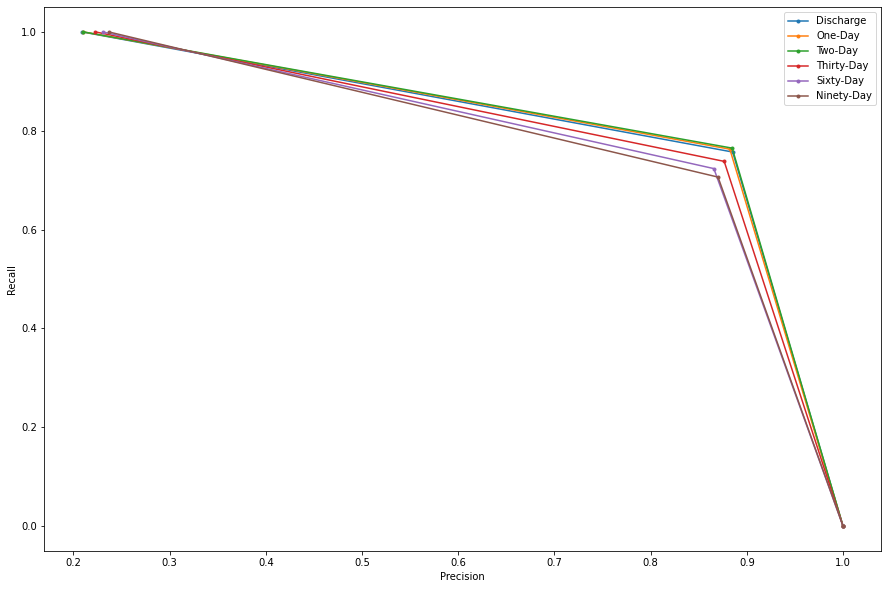

In [62]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(15,10))

for (pred, test, label) in [
        (y_discharge_pred, y_discharge_test, 'Discharge')
        , (y_one_day_pred, y_one_day_test, 'One-Day')
        , (y_two_day_pred, y_two_day_test, 'Two-Day')
        , (y_thirty_day_pred, y_thirty_day_test, 'Thirty-Day')
        , (y_sixty_day_pred, y_sixty_day_test, 'Sixty-Day')
        , (y_ninety_day_pred, y_ninety_day_test, 'Ninety-Day')
    ]:
    precision, recall, thresholds = precision_recall_curve(test, pred)
    plt.plot(precision, recall, marker='.', label=label)

# axis labels
plt.xlabel('Precision')
plt.ylabel('Recall')
# show the legend
plt.legend()
# show the plot
plt.show()

#### MCC F1

In [63]:
from mcc_f1 import plot_mcc_f1_curve

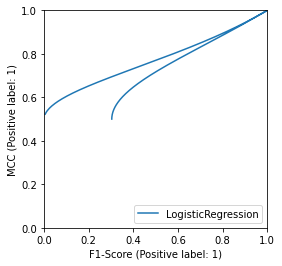

In [65]:
plot_mcc_f1_curve(lr_discharge, X_test, y_discharge_pred)

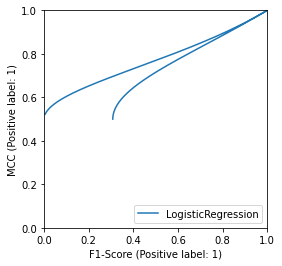

In [66]:
plot_mcc_f1_curve(lr_one_day, X_test, y_one_day_pred)

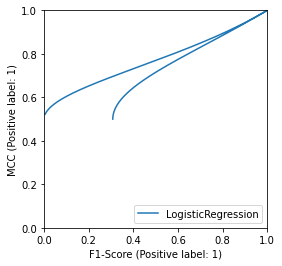

In [67]:
plot_mcc_f1_curve(lr_two_day, X_test, y_two_day_pred)

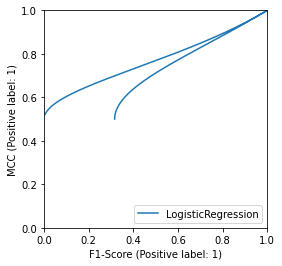

In [68]:
plot_mcc_f1_curve(lr_thirty_day, X_test, y_thirty_day_pred)

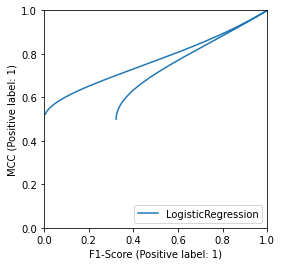

In [69]:
plot_mcc_f1_curve(lr_sixty_day, X_test, y_sixty_day_pred)

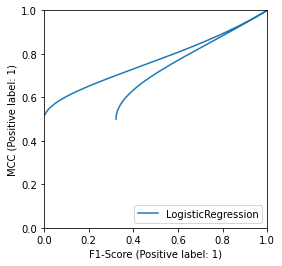

In [70]:
plot_mcc_f1_curve(lr_ninety_day, X_test, y_ninety_day_pred)

#### Prediction probability distribution

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


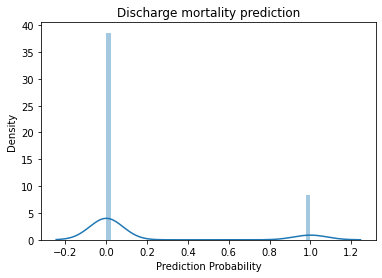

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


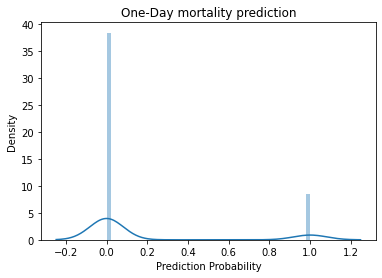

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


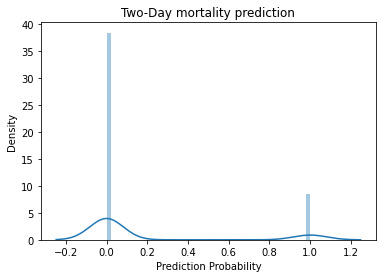

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


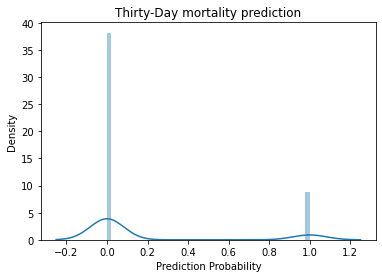

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


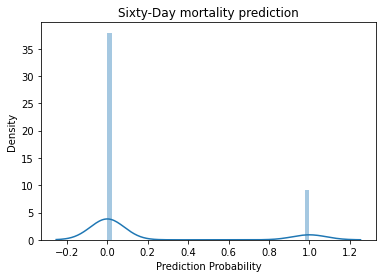

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


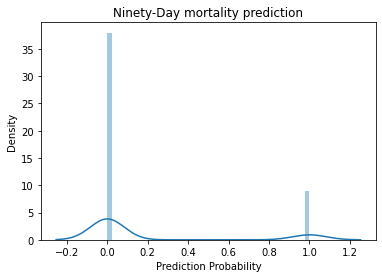

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

for (pred, label) in [
        (y_discharge_pred, 'Discharge mortality prediction')
        , (y_one_day_pred, 'One-Day mortality prediction')
        , (y_two_day_pred, 'Two-Day mortality prediction')
        , (y_thirty_day_pred, 'Thirty-Day mortality prediction')
        , (y_sixty_day_pred, 'Sixty-Day mortality prediction')
        , (y_ninety_day_pred, 'Ninety-Day mortality prediction')
    ]:
    sns.distplot(pred, hist=True, rug=False, axlabel='Prediction Probability')
    plt.title(label)
    plt.show()